# Mapping paddy rice agriculture from MODIS surface reflectance data

An implementation of the algorithm described in "Mapping Paddy Rice Agriculture in South and Southeast Asia using multi-temporal MODIS images" ([Xiao et al., 2006](https://www.sciencedirect.com/science/article/abs/pii/S0034425705003433?via%3Dihub)), using Google Earth Engine to allow rapid exploration and export of the results for any required areas and times.

The Google Earth Engine (GEE) version of the algorithm was originally implemented in the GEE Javascript API by Harry Gibson whilst working at the Malaria Atlas Project. This python implementation of the code has been translated and assembled into a notebook for interview for the Ordnance Survey Data Scientist role.

### Overview of the algorithm

This algorithm seeks to model the locations of paddy rice agriculture based on the planting/growth pattern of the crop cycle. Specifically, paddy rice is characterised as growing in areas which are frequently, but not permanently, flooded. The young plants are transplanted into flooded fields whereupon they grow rapidly, leading to an increase in remotely-sensed indices of vegetation health such as EVI and NDVI. 

Therefore, after first excluding from consideration data relating to areas which are permanently flooded, permanently green, or otherwise unsuitable for paddy rice growth, the algorithm identifies pixels/times representing the onset of flooding, and from each such pixel looks to find a rapid increase in EVI within 40 days of this onset. Pixels that reach a certain threshold of EVI within 40 days of the onset of flooding are proposed to be likely to be paddy rice.


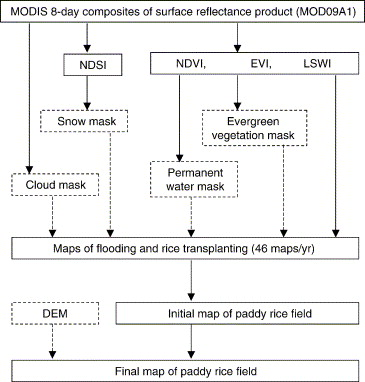


### Overview of the implementation

The algorithm was developed against the MODIS surface reflectance product MOD09A1, which comprises 8-daily global 500m-resolution images. In order to create a paddy rice map for a given year, a minimum of two years' images (i.e. over 90 images) are required, and then many derived datasets are requuired to be developed from each of those images before even embarking on the multi-temporal part of the analysis. Exploring the success of the algorithm globally is therefore enormously expensive and so I chose to use Google Earth Engine. As well as providing ready access to the required source data, this platform  uses a lazy execution paradigm which means that data are only computed when, and at the maybe-downsampled resolution, they are required.  This makes it feasible to run the algorithm globally for numerous years.

The programming style used by the GEE API is functional; functions to process images are defined in client code and then executed on GEE servers in a lazy way, and collections of multiple images or other features are processed by mapping the function over the collection rather than using client side loops or other control structures.

For the purposes of this demonstration notebook, all the necessary code is present in the notebook. In reality we would of course move most of the core functions to external modules in order to keep the notebook cleaner for data exploration. We also limit the execution to create the map for a single year at a time, again to keep exploration easier.


# Begin implementation

### Imports and constants

In [1]:
import ee
from functools import partial

In [2]:
ee.Initialize()

In [3]:
# Define a single year within the MODIS period (2000-present) to create and inspect maps for
YEAR_TO_MAP = 2002

# Reference to the SR and landcover collections needed in the EE catalog
SOURCE_COLLECTION_ID = "MODIS/006/MOD09A1"
LANDCOVER_COLLECTION_ID = "MODIS/006/MCD12Q1"
ELEVATION_IMG_ID = "USGS/GTOPO30"

Get the various dates that are needed to filter the imagery for the different steps

The rice calculation algorithm needs input images for 40 days before the first date for which output is required, and for each input image we need to have the corresponding full calendar year's worth of data to compute the masking. So, to complete the rice map for a given year, we also need the previous year's data. Define a version of the source collection that is filtered to these dates.

In [4]:
_years = ee.List.sequence(YEAR_TO_MAP-1, YEAR_TO_MAP)
_start_date = ee.Date.fromYMD(YEAR_TO_MAP-1, 1, 1)
_end_date = ee.Date.fromYMD(YEAR_TO_MAP, 12, 31)

In [5]:
_input_collection = ee.ImageCollection(SOURCE_COLLECTION_ID).filterDate(_start_date, _end_date)
_input_landcover = ee.ImageCollection(LANDCOVER_COLLECTION_ID)
_elev_image = ee.Image(ELEVATION_IMG_ID)

### MOD09A1 NORMALISED INDEX COMPUTATION FUNCTIONS 

Define functions to compute the various normalised indices used in the algorithm, on a single
MOD09A1 image. (These would otherwise be moved to an external module)

In [6]:
def unScale(image):
    return image.float().divide(10000)

def computeNDVI(image):
    nir = unScale(image.select('sur_refl_b02'))
    red = unScale(image.select('sur_refl_b01'))
    ndvi = (nir.subtract(red)).divide(nir.add(red))
    return ndvi.rename('ndvi').set('system:time_start', image.get('system:time_start'))

def computeLSWI(image):
    nir = unScale(image.select('sur_refl_b02'))
    swir = unScale(image.select('sur_refl_b06'))
    lswi = (nir.subtract(swir)).divide(nir.add(swir))
    return lswi.rename('lswi').set('system:time_start', image.get('system:time_start'))

def computeEVI(image):
    nir = unScale(image.select('sur_refl_b02'))
    red = unScale(image.select('sur_refl_b01'))
    blue = unScale(image.select('sur_refl_b03'))
    evi = (nir.subtract(red)
        .divide(nir.add(red.multiply(6.0)).subtract(blue.multiply(7.5)).add(1.0))
        .multiply(2.5)
        .clamp(0.0, 1.0))
    return evi.rename('evi').set('system:time_start', image.get('system:time_start'))

def computeNDSI(image):
    # the referenced paper used nir band but most other references use swir
    # for example doi:10.1016/j.rse.2003.10.016 as well as 
    # https://nsidc.org/support/faq/what-ndsi-snow-cover-and-how-does-it-compare-fsc
    # Doing it with nir and a threshold of snow = 0.4+ gives completely nonsense results
    # so i assume this was a misprint
    swir = unScale(image.select('sur_refl_b06'))
    green = unScale(image.select('sur_refl_b04'))
    ndsi = (green.subtract(swir)).divide(green.add(swir))
    return ndsi.rename('ndsi').set('system:time_start', image.get('system:time_start'))


## ALGORITHM STEP-BY-STEP

In creating this implementation I have extracted the various steps described in the paper narrative in order to implement them in code. 

Steps are presented according to how they appear in the text but are not necessarily executed in this order: we are simply defining the functions at this point. Lazy execution means that the actual computation only happens when we display or export the resulting maps.

## Define functions to compute all image-by-image masks

These masks apply to each image independently. Note that each one returns a binary image that is 0 where the image should be masked and 1 elsewhere.

##### Mask step 1: -  Compute flooded areas 

These are defined as pixels where LSWI is nearly as high, or higher, than NDVI or EVI


In [7]:
def computeFlooded(image):
    lswi = computeLSWI(image)
    evi = computeEVI(image)
    ndvi = computeNDVI(image)
    test = evi.min(ndvi)
    flood = lswi.add(0.05).gte(test)
    return flood.rename('flood').set('system:time_start', image.get('system:time_start'))

##### Mask step 2: - Cloud cover mask

"*Exclude pixels where marked as cloud in the QC band, and also exclude pixels where blue band 
reflectance GTE 0.2*"

This description is somewhat inconclusive of what they actually did. From the MODIS doc: 
    
    ```bits 0-1 are a cloud mask read from MOD35 and bit 10 is a cloud mask generated by PGE11's
    internal cloud algorithm```
    
Xiao et al does not specify which of these masks was used so we'll extract each mask from the data 
(using bitwise operators) and mask where either is true (boolean OR)
   

In [8]:
def compute_cloud_or_blue_mask(image):
    """ Identify pixels where either MODIS cloud mask is set OR blue band >= 0.2

    NB returns 0 where cloudy and 1 otherwise, for use with updateMask"""
    blue = unScale(image.select('sur_refl_b03'))
    # from MODIS doc: "All cloud information should be derived from State QA SDSs" (not the band qa)
    # So we select that band and for clarity separate it into two separate mask images
    qa = image.select('StateQA')
    # bits 0-1 are one of the recorded cloud masks with the following values: 
    # 00 = clear, 01 = cloudy, 10 = mixed, 11 = unset, assumed clear
    cloudMOD35 = (qa.bitwise_and(3).eq(1)).Or(qa.bitwise_and(3).eq(2))
    # bit 10 is the other recorded cloud mask with key: 0 = clear, 1 = cloud
    cloudInternal = qa.bitwise_and(1024).eq(1024)
    return (cloudMOD35
        .Or(cloudInternal)
        .Or(blue.gte(0.2)) 
        .Not() #  negate for the EE mask expectations
        .rename('cloud').set('system_time_start', image.get('system:time_start')))

In [8]:
def computeCloudMODISMask(image):
    qa = image.select('StateQA');
    # from MODIS doc: "bits 0-1 are a cloud mask read from MOD35"
    # bits 0-1 key: 00 = clear, 01 = cloudy, 10 = mixed, 11 = unset, assumed clear
    cloudMOD35 = (qa.bitwise_and(3).eq(1)).Or(qa.bitwise_and(3).eq(1));
    return (cloudMOD35
        .Not()
        .rename('cloud').set('system_time_start', image.get('system:time_start')))

def computeCloudInternalMask(image):
    qa = image.select('StateQA')
    # from MODIS doc: "bit 10 is a cloud mask generated by PGE11's internal cloud algorithm"
    # bit 10 key: 0 = clear, 1 = cloud
    cloudInternal = qa.bitwise_and(1024).eq(1024)
    return (cloudInternal
        .Not()
        .rename('cloud').set('system_time_start', image.get('system:time_start')))

##### Mask step 3: - Snow mask

"*Filter snow pixels based on NDSI and NIR reflectance, where NDSI > 0.40 and NIR > 0.11*"

NB NDSI has been implemented using SWIR band, not NIR, but Xiao et al state NIR - this appears 
wrong; I have used SWIR in the NDSI function but retained NIR in the threshold check.

In [9]:
def compute_snow_mask(image):
    ndsi = computeNDSI(image)
    nir = image.select('sur_refl_b02')
    snow = ndsi.gte(0.40).bitwise_and(nir.gte(0.11)).Not()
    return snow.rename('snow').set('system:time_start', image.get('system:time_start'))

##### Mask step 4: - Identify water areas 

*Flag pixels as water where NDVI < 0.10 and NDVI < LSWI*

It's unclear from the paper why they don't simply use the "flooded" function that was defined in step 1, rather than redefining a slightly different version that doesn't use EVI.

In [10]:
def compute_water(image):
    lswi = computeLSWI(image)
    ndvi = computeNDVI(image)
    water = ndvi.lt(0.1).And(ndvi.lt(lswi))
    return water.rename('water').set('system:time_start', image.get('system:time_start'))

##### Mask step 5: - Define static masks based on elevation, slope and ocean

Areas higher than 2000m or steeper than 2 degrees are excluded. 

For this implementation we also use a landcover dataset (MCD12Q1) as a faster way to exclude all non-land pixels so that the algorithm can be run over wider extents without wasting time looking in the ocean. 

In [11]:
elev_mask = _elev_image.lte(2000)
slope_mask = ee.Terrain.slope(_elev_image).lte(2)

def get_landcover_water_mask(year):
    modis_landcover_coll = ee.ImageCollection("MODIS/006/MCD12Q1")
    modis_lc_image = (modis_landcover_coll.filter(ee.Filter.calendarRange(
                     year, year, 'year'))
                     .first())
    igbp_image = modis_lc_image.select('LC_Type1')
    ocean_mask = igbp_image.neq(17)
    return ocean_mask


## Define functions to compute time-series based masks

The functions defined so far each operate on a single image at once. Now we define functions that rely on the image series. With these functions we calculate a separate mask for each year of the period of records and each image is masked with the corresponding year's mask.

##### Mask step 6: - Annual Permanent water mask

*Identify pixels covered by water, then exclude from the analysis those pixels which are water for more than 10 images (8 day blocks) i.e. 80 days per year*

Any pixels identified as water covered for more than this will be treated as permanent water and not analysed for the wetting/drying cycle that triggers rice detection. 

I've modified this to also flag pixels which are water for more than 30% of the images, in case there are many missing values and the hardcoded 10-occurrence threshold isn't valid.

*Implementation note:*
```
Note that the .map() function needs a callable which takes one argument. To map over a list of years for a specified ImageCollection we need to pass both the ImageCollection and a reference to the year in question. We use `functools.partial` to convert the two-argument function and its first argument (the imagecollection) into a second function taking only one argument (the year), by creating a closure. This can be used within an EE map, over the years.```

In [12]:
def get_annual_permanent_water(collection, year):
    """Returns a mask image to select pixels which are water in >10 images AND >30% of them"""
    start = ee.Date.fromYMD(year, 1, 1)
    # this approach enables us to use non-calendar years e.g. april-april or whatever
    stop = start.advance(0, 'year').advance(12, 'month').advance(0,'day')
    waterYear = (collection.filter(ee.Filter.date(start, stop))
        .map(compute_water))
    waterYearCount = waterYear.sum()
    waterYearMean = waterYear.mean()
    # let's also try to implement a threshold for the average because the count will vary 
    w = waterYearCount.gt(10).And(waterYearMean.gt(0.3))
    return (w.set('year', year)
        .set('system:time_end',ee.Date.fromYMD(year, 1, 1).advance(1, 'year'))
        .set('system:time_start',ee.Date.fromYMD(year, 1, 1))
        .Not())

##### Mask step 7: - Mask out evergreen forest

Identify evergreen forest pixels using the algorithm:

    "Identify areas where NDVI > 0.7 for at least 20 8-day composites per year, to flag evergreen forests"

NB the paper did not use a landcover map to do this.

In [23]:
def get_year_is_evergreen(collection, year):
    start = ee.Date.fromYMD(year, 1, 1)
    stop = start.advance(12, 'month').advance(0, 'day')
    ndviGreenYearColl = (collection.filter(ee.Filter.date(start, stop))
          .map(lambda img: computeNDVI(img).gt(0.7))
    )
    ndviGreenYearCount = ndviGreenYearColl.sum()
    # ndviGreenYearMean = ndviGreenYearColl.mean()
    # TODO - maybe a mean value too if n is say between 10 and 20? 
    forestYear = ndviGreenYearCount.gt(20).rename("maybeForest")
    return (forestYear.set('year', year)
        .set('system:time_end',ee.Date.fromYMD(year, 1, 1).advance(1, 'year'))
        .set('system:time_start',ee.Date.fromYMD(year, 1, 1)))
    

##### Mask step 8: - Identify non-forest evergreen pixels

Identify other evergreen pixels (e.g. grass)  using the algorithm:

    "Identify areas where LSWI is always GTE 0.10, to flag natural evergreen (non forest) vegetation"
    
NB: This has been tuned by the authors for the original study area; it may not be globally suitable!


In [24]:
def get_year_is_evergreen_nonforest(collection, year):
    start = ee.Date.fromYMD(year, 1, 1)
    stop = start.advance(12, 'month').advance(0, 'day')
    shrubby_year_img = (collection.filter(ee.Filter.date(start, stop))
          .map(lambda img: computeLSWI(img).gte(0.1))
    ).reduce(ee.Reducer.allNonZero()).rename("maybeShrubbery")
    return (shrubby_year_img.set('year', year)
        .set('system:time_end',ee.Date.fromYMD(year, 1, 1).advance(1, 'year'))
        .set('system:time_start',ee.Date.fromYMD(year, 1, 1)))
    

##### Mask step 9: - Extra step (not in paper): make a forest mask from the MODIS landcover data

For each annual landcover (MCD12Q1) image, select the IGBP classes representing forest and use these as an additional masking step as well as the forest estimates based on reflectance indices above. Using Earth Engine means there's minimal extra overhead in doing this  (downloading data etc) and it is likely to provide a more accurate estimate of true forest cover.

Here we define a collection that has one binary image for each image in the incoming landcover collection, representing whether a pixel is defined as a forest landcover class in the IGBP classification scheme.

In [31]:
def get_mcd12q1_forest(image):
    igbp = image.select('LC_Type1')
    # igbp evergreen forest classes 1, 2; deciduous classes 3, 4, mixed forest class 5
    year = ee.Date(image.get('system:time_start')).get('year')
    igbpForest = igbp.eq(1).Or(igbp.eq(2)).Or(igbp.eq(3)).Or(igbp.eq(4)).Or(igbp.eq(5))
    return (igbpForest
        .rename('evergreen_landcover')
        .set('system:time_start',image.get('system:time_start'))
        .set('year', year)
        .Not())
annual_mcd12q1_forest = _input_landcover.map(get_mcd12q1_forest)

## Apply all masking and preprocessing

Now we have defined all the masking and image-processing functions, we can use them to process the surface reflectance data, and then implement the core rice-detection algorithm.

First we apply all the masking to the incoming SR data. 

##### Define function to apply each of the single-image masks in turn

In [18]:
ocean_mask = get_landcover_water_mask(YEAR_TO_MAP)
def apply_all_modis_masks(img):
    cloud_mask_both = compute_cloud_or_blue_mask(img) # 1 = clear 0 = cloud
    snow_mask = compute_snow_mask(img)
    return (img.set('year', ee.Date(img.get('system:time_start')).get('year'))
        .updateMask(ocean_mask)
        .updateMask(elev_mask)
        .updateMask(slope_mask)
        .updateMask(cloud_mask_both)
        .updateMask(snow_mask))


##### Map the function over the source collection

In [33]:
masked_modis_series = _input_collection.map(apply_all_modis_masks)

##### Create annual masks based on water and forest

The functions to do this map over years (the years for which we require output, currently but not necessarily set to a single year).

They need both a year and an imagecollection as input. We use functools.partial to wrap them into functions that need only the year as input, to use with the EE map syntax.

In [20]:
year_watermask_mapper = partial(get_annual_permanent_water, masked_modis_series)
permanent_water_mask_by_year = ee.ImageCollection.fromImages(
    _years.map(year_watermask_mapper).flatten())

In [25]:
year_evergreen_mapper = partial(get_year_is_evergreen, masked_modis_series)
evergreen_forest_by_year = ee.ImageCollection.fromImages(
    _years.map(year_evergreen_mapper).flatten())

In [26]:
year_shrubbery_mapper = partial(get_year_is_evergreen_nonforest, masked_modis_series)
shrubbery_by_year = ee.ImageCollection.fromImages(
    _years.map(year_shrubbery_mapper).flatten())

##### Combine the two types of evergreen estimate into a single image per year

In [27]:
def combine_evergreen_estimates(image):
    forest_band = image.select("maybeForest")
    shrubbery_band = image.select("maybeShrubbery")
    return (forest_band.Or(shrubbery_band)
            .rename("evergreen")
            .set('system:time_end',image.get('system:time_end'))
            .set('system:time_start',image.get('system:time_start'))
            .set('year', image.get('year'))
            .Not())

evergreen_mask_by_year = (evergreen_forest_by_year
                         .combine(shrubbery_by_year)
                         .map(lambda img: combine_evergreen_estimates(img)))

##### Combine the annual evergreen and annual water masks

For each year, combine the evergreen and permanent water masks derived above into a single 2-band image, and make them into a collection with one such image per year

In [28]:
annual_masks = permanent_water_mask_by_year.combine(evergreen_mask_by_year)

##### Combine the annual evergreen/water and landcover masks

Because the landcover masks come from a different dataset to the other masks, the images have different IDs and so we cannot use the .combine() function to join them into a single mask dataset.

Instead, we define a join that will combine them based on the year property:

In [32]:
get_annual_LC_join = ee.Join.saveBest(**{
  "matchKey": "lcImage",
  "measureKey": "yearDiff"
})

landcover_join_result = get_annual_LC_join.apply(**{
  "primary": annual_masks,
  "secondary": annual_mcd12q1_forest,
  "condition": ee.Filter.maxDifference(**{
    "difference": 5, # allow some offset as we may have more recent rice images than landcover ones
    "leftField": "year",
    "rightField": "year"
  })
})

# The join saves the matched LC image as a property on the incoming image, not as a band.
# We need to transfer it to a band:
def extract_lc_joinresult(image):
    lc_image = ee.Image(image.get('lcImage'))
    image = ee.Image(image).addBands(lc_image)
    return image
    
annual_masks = landcover_join_result.map(lambda img: extract_lc_joinresult(img))

##### Apply the annual masks to the images

For each image in the collection, apply the water / evergreen / landcover masks for the corresponding year

To do this, we join the source image to the annual mask image based on the year property; extract the join results from properties to bands, and then update the image's mask accordingly.

In [34]:
get_annual_mask_join = ee.Join.inner()
join_res = get_annual_mask_join.apply(**{
  "primary": masked_modis_series,
  "secondary": annual_masks,
  "condition": ee.Filter.equals(**{
    "leftField": "year",
    "rightField": "year"
  })
})

def extract_mask_join_results(feature):
    image = ee.Image(feature.get('primary'));
    annual_mask = ee.Image(feature.get('secondary'));
    masked = (image
        .updateMask(annual_mask.select('water'))
        .updateMask(annual_mask.select('evergreen'))
        .updateMask(annual_mask.select('evergreen_landcover')))
    return masked; 

fully_masked_series = ee.ImageCollection(
    join_res.map(lambda img: extract_mask_join_results(img)))


## Implement rice detection

The ImageCollection `fully_masked_series` now contains the source SR imagery, with all the different masks applied to exclude pixels that can't be considered as rice for any of the given reasons.

We can now proceed to run the main rice-detection algorithm against this collection.

As a reminder the core principle of the algorithm is to track (on a pixel-wise basis) the point at which flooding occurs, and the point at which greening occurs. Specifically, we look for pixels where the EVI value reaches half of the maximum value ever seen in that pixel within 5 x 8-day composites (40 days) following the date of the onset of flooding (and, assumed, transplanting of rice seedlings). Where this occues and all the masking conditions are met, this is considered to be an indicator of paddy rice.

#### 2. a. Identify dates when flooding onset occurs

That is, in each image find pixels which are flooded but were not flooded in the previous image

In [39]:
# Get a series of binary images showing flooded pixels
flooded_images = fully_masked_series.map(
    lambda image: computeFlooded(image))

# join each is-a-flood image to the previous one temporally
save_prev_flood_join = ee.Join.saveFirst(**{
  "matchKey": "prevFlood",
  "ordering": "system:time_start",
  "ascending": False
})

floods_with_prev_img = save_prev_flood_join.apply(**{
  "primary": flooded_images,
  "secondary": flooded_images,
  "condition": ee.Filter.greaterThan(**{
    "leftField": "system:time_start",
    "rightField": "system:time_start"
  })
})

# build a collection of images that are 1 where a pixel is flooded now but wasn't in previous image

def extract_flood_join_results(joined_image):
    prev_image = ee.Image(joined_image.get('prevFlood'))
    this_image = ee.Image(joined_image)
    is_new_flood = this_image.And(prev_image.Not())
    return (is_new_flood.set('system:time_start', 
                          this_image.get('system:time_start'))
            .rename('flood-starts'))

flood_initiations = floods_with_prev_img.map(extract_flood_join_results)
flood_initiations = ee.ImageCollection(flood_initiations)

### 2. b. Identify maximum EVI values reached by each pixel

For now, we're doing this as max _ever_ reached in each pixel over the whole series, rather than per crop cycle.

For the algorithm to be globally applicable we would need a local definition of the start/end of crop cycle in the year.

In [36]:
max_evi_threshold = fully_masked_series.map(
    lambda image: computeEVI(image)
).max().divide(2.0)

### 2. c. Identify pixels where EVI was at least 50% of this maximum value

In each image, calculate the EVI and mark the locations where it is at least 50% of the highest EVI value ever recorded in that pixel.

At the same time (for convenience) we calculate a DateRange representing the 40 days prior to the date of each image, and attach it to the image.

In [37]:
def evi_over_threshold(threshold_image, test_image):
    forty_days_ago = (ee.Date(test_image.get('system:time_start'))
                      .advance(-40, 'day'))
    forty_day_window = ee.DateRange(forty_days_ago, 
                                    test_image.get('system:time_start'))
    return (computeEVI(test_image)
            .gt(threshold_image)
            .rename('high-evi')
            .set('system:time_start', 
                 test_image.get('system:time_start'))
            .set('forty_day_window', forty_day_window))

evi_over_threshold_mapper = partial(evi_over_threshold, max_evi_threshold)
evi_over_threshold_dates = fully_masked_series.map(evi_over_threshold_mapper)


### 2. d. Identify from the high-EVI pixels those which are within 40 days of a flooding event

We do this by joining the high-EVI images to the flood images, based on a key of the forty-day window we calculated.

This will provide our output rice estimate map.

In [40]:
# This join needs to look at more than one preceding image so use a saveAll not saveBest
save_flood_onsets_join = ee.Join.saveAll(**{
  "matchesKey": 'floodsInLast40D',
  "ordering": 'system:time_start',
  "ascending": False
})

green_with_recent_floods = save_flood_onsets_join.apply(**{
    "primary": evi_over_threshold_dates,
    "secondary": flood_initiations,
    "condition": ee.Filter.dateRangeContains(**{
        "leftField": "forty_day_window",
        "rightField": "system:time_start"
  })
})

In [41]:
def extract_rice_join_results(image):
    # in the saveAll join, the whole matching set of images are saved onto the 
    # specified property of each image
    recent_floods_coll = ee.ImageCollection.fromImages(image.get('floodsInLast40D'))
    any_recent_floods = recent_floods_coll.reduce(ee.Reducer.anyNonZero())
    is_it_green = ee.Image(image)
    is_it_rice = is_it_green.And(any_recent_floods);
    return (is_it_rice.rename('rice')
        .set('system:time_start', image.get('system:time_start')))

rice_image_collection = green_with_recent_floods.map(extract_rice_join_results)
rice_image_collection = ee.ImageCollection(rice_image_collection)

In [46]:
rice_in_year = ee.Image(rice_image_collection
                        .filterDate(ee.Date.fromYMD(
                            YEAR_TO_MAP, 1, 1), ee.Date.fromYMD(YEAR_TO_MAP, 12, 31))
                       .reduce(ee.Reducer.anyNonZero()))

In [47]:
rice_in_year = rice_in_year.updateMask(rice_in_year)

## Output

This, finally, defines our rice map for the year in question. Now we visualise it and compare with the published data.

It is at the point we add the data to the map and view it that the computation is actually triggered.

In [42]:
import folium

In [43]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = "Map Data © Google Earth Engine",
        name = name,
        overlay = True,
        control = True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer

In [58]:
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [62]:
rice_map = folium.Map(location=[17.5, 90], zoom_start=5, height=500)

In [63]:
# Add custom basemaps
basemaps['Google Maps'].add_to(rice_map)
basemaps['Google Satellite Hybrid'].add_to(rice_map)

In [64]:
rice_map.add_ee_layer(rice_in_year, {"palette":['000000', 'FF0000']}, "RICE")

In [65]:
rice_map.add_child(folium.LayerControl())

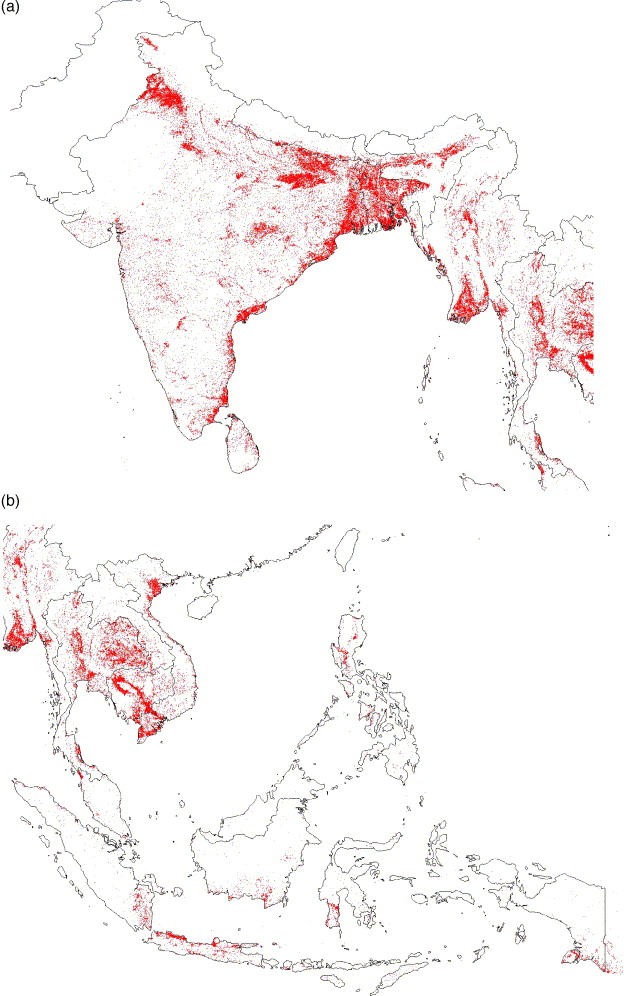

In [42]:
Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…